In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tarfile
import glob
from matplotlib.colors import LogNorm


Matplotlib created a temporary config/cache directory at /scratch/slurm-job.854520/matplotlib-s6w81xre because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [26]:
filter_dir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order'
sample_target = 'TCGA-AO-A0JM-01A-21R-A056-07'

plot_dir = os.path.join(filter_dir, 'plots')
base_plot = sample_target

In [2]:
tar_file_OHSU = '/cluster/work/grlab/projects/projects2020_OHSU/share_OHUS_PNLL/expanded-filters_OHSU-results_Mar19-2023/OHSU_March19-2023_expanded-filters_results.tar.gz'

In [3]:
base_eth = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order'

In [4]:
one_file_eth = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order/G_TCGA-AO-A0JM-01A-21R-A056-07_SampleLim0.0CohortLimNoneAcrossNone_FiltNormalsGtexCohortCohortlim0.0Across1.tsv.gz'

In [5]:
# Reads > 0 or 1 sample any read
# Any read would be > 0 

In [6]:
# ETH Names
eth_all = glob.glob(os.path.join(base_eth, 'G*'))

In [7]:
# OHSU Names
with tarfile.open(tar_file_OHSU, "r:*") as tar:
    ohsu_all = tar.getnames()

In [8]:
# Get file pairs
file_pair = {}
for idx_eth, eth in enumerate(eth_all):
    pattern = os.path.basename(eth).replace('G_', '').replace('.gz', '') #.replace('.0CohortLim','CohortLim')
    for idx_ohsu, ohsu in enumerate(ohsu_all):
        if pattern in ohsu:
            file_pair[eth] = ohsu

            

In [9]:
len(file_pair)

230

# Collect Data to plot

In [10]:
# sample = TCGAAOA0JM01A21RA05607all
restrict = 'TCGA-AO-A0JM-01A-21R-A056-07'
df = {'sample' : [], 
      'filter_foreground' : [], 
      'filter_background' : [], 
      'size_ohsu' : [], 
      'size_eth' : [], 
      'size_intersection' : [], 
      'size_ohsu\eth' : [], 
      'size_eth\ohsu' : []}
with tarfile.open(tar_file_OHSU, "r:*") as tar: #OHSU
    for eth, ohsu in file_pair.items(): # ETH
        if (not restrict) or restrict in eth: #Restrict to category of interest
            try:
                df_ohsu = pd.read_csv(tar.extractfile(ohsu), header=0, sep="\t")
                #print(eth)
                df_eth = pd.read_csv(eth, sep="\t", usecols = ['kmer'])
                #print(df_eth.shape)
                df_eth = set(df_eth['kmer'])
                #print(len(df_eth))
                df_ohsu = set(df_ohsu['kmer'])
                name = os.path.basename(ohsu).replace('.tsv', '').split('_')
                df['sample'].append(name[1])
                df['filter_foreground'].append(name[2])
                df['filter_background'].append(name[3])
                df['size_ohsu'].append(len(df_ohsu))
                df['size_eth'].append(len(df_eth))
                df['size_ohsu\eth'].append(len(df_ohsu.difference(df_eth)))
                df['size_eth\ohsu'].append(len(df_eth.difference(df_ohsu)))
                df['size_intersection'].append(len(df_ohsu.intersection(df_eth)))
            except:
                continue


In [11]:
df = pd.DataFrame(df)

# Path Tests

In [12]:
back_ = set()
foregr_ = set()
for i in eth_all:
    if 'FiltNormalsGtexC' in i:
        if 'TCGA-AO-A0JM-01A-21R-A056-07' in i:
            back_.add(os.path.basename(i).split('_')[3])
            foregr_.add(os.path.basename(i).split('_')[2])
print('foreground')
for i in foregr_:
    print(i)
print('background')
for i in back_:
    print(i)

foreground
SampleLim0.0CohortLim2.0Across1
SampleLim0.0CohortLimNoneAcrossNone
SampleLim0.0CohortLim2.0Across5
SampleLim0.0CohortLim0.0Across5
SampleLim0.0CohortLim0.0Across1
background
FiltNormalsGtexCohortCohortlim0.0Across1metadata2.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across10.tsv.gz
FiltNormalsGtexCohortCohortlim3.0Across1.tsv.gz
FiltNormalsGtexCohortCohortlim1.0Across2.tsv.gz
FiltNormalsGtexCohortCohortlim0.0Across1metadata.tsv.gz


In [13]:
# FiltNormalsGtexCohortCohortlim0.0Across0.tsv


# Plot Set size

In [14]:
df = df.sort_values('size_intersection')
df['index'] = np.arange(len(df))

In [15]:
def plot_text(Y, T):
    Y = np.array(Y)
    T = np.array(T)
    change_val = [i for i in np.arange(len(Y) - 1) if Y[i] != Y[i - 1]]    
    weighted = [change_val[i] + (change_val[i+1] - change_val[i]) / 2 for i, x in enumerate(change_val[:-1])]
    X = [np.floor(change_val[i] + (change_val[i+1] - change_val[i]) / 2) for i, x in enumerate(change_val[:-1])]
    Y = Y[np.array(change_val[:-1])]
    T = T[np.array(change_val[:-1])]
    p_prev = 0 
    percent_diff = 6
    
    for x, y, p in zip(X, Y, T):
        if (p > p_prev + (p_prev/percent_diff)) or (p < p_prev - (p_prev/percent_diff)):
            plt.text(x - 0.5 , y + (y/10), p)
        p_prev = p 

In [16]:
def plot_text_all(X, Y, T):
    for x, y, p in zip(X, Y, T):
        plt.text(x, y, p)
        #plt.text(x - 0.5 , y + (y/10), p)


/scratch/slurm-job.854520/ipykernel_3621122/2319188010.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
/scratch/slurm-job.854520/ipykernel_3621122/2319188010.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
/scratch/slurm-job.854520/ipykernel_3621122/2319188010.py:12: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order/plots/TCGA-AO-A0JM-01A-21R-A056-07_Barplot_ovelap.pdf


/scratch/slurm-job.854520/ipykernel_3621122/2319188010.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


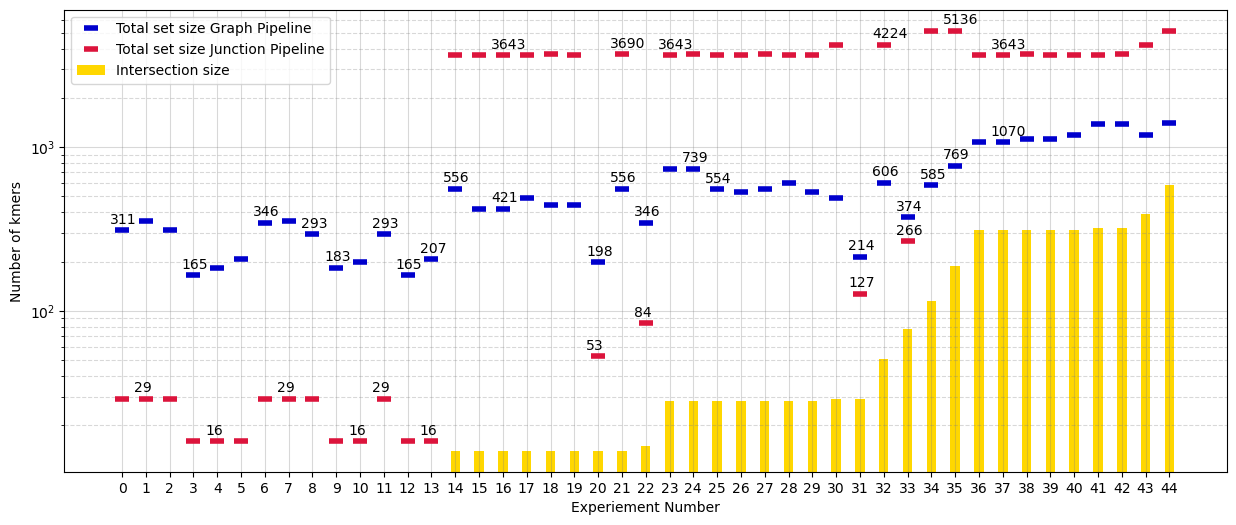

In [27]:
colorgrid = 'grey'
alpha_grid = 0.3
marker_size = 10
mew = 4
color1 = 'gold'
color2 = 'crimson'
color4 = 'mediumblue'
colorgrid = 'grey'

plt.figure(figsize=(15, 6))
plt.grid(b=True, axis = 'both', which='major', color=colorgrid, linestyle='-', alpha=alpha_grid)
plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)
width = 0.4
plt.bar(df['index'], df['size_intersection'], width=width, 
        color=color1, label='Intersection size')
plt.plot(df['index'], df['size_eth'], alpha=1, color=color4,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Graph Pipeline')
plt.plot(df['index'], df['size_ohsu'], alpha=1, color=color2,
         linestyle = 'None', markerfacecolor='None', marker="_", markersize=marker_size, markeredgewidth=mew,
         label = 'Total set size Junction Pipeline')

plot_text(df['size_ohsu'], df['size_ohsu'])
plot_text(df['size_eth'], df['size_eth'])
#plot_text_all(df['index'], df['size_intersection'], df['size_intersection'])

plt.xticks(np.arange(len(df['index'])))
plt.legend()
plt.ylabel('Number of kmers')
plt.xlabel('Experiement Number')
plt.yscale('log')


save = True
name = 'Barplot_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
fig.show()

# Plot Intersections

In [18]:
df.columns

Index(['sample', 'filter_foreground', 'filter_background', 'size_ohsu',
       'size_eth', 'size_intersection', 'size_ohsu\eth', 'size_eth\ohsu',
       'index'],
      dtype='object')

In [19]:
foreg_expr = [None, 0, 2, 0, 2]
foreg_sample = [None, 1, 1, 5, 5]

In [20]:
# plt.plot(foreg_expr, np.arange(len(foreg_expr)), linestyle = 'None', marker="o")
# plt.plot(foreg_sample, np.arange(len(foreg_sample)), linestyle = 'None', marker="x")
# plt.invert_yaxis()

In [21]:

order_foreground = ['SampleLim0.0CohortLimNoneAcrossNone', 'SampleLim0.0CohortLim0.0Across1',
           'SampleLim0.0CohortLim2.0Across1', 'SampleLim0.0CohortLim0.0Across5',
           'SampleLim0.0CohortLim2.0Across5']
order_background = ['FiltNormalsGtexCohortCohortlim3.0Across10', 
                     'FiltNormalsGtexCohortCohortlim3.0Across2', 
                     'FiltNormalsGtexCohortCohortlim1.0Across10',
                     'FiltNormalsGtexCohortCohortlim0.0Across10', 
                     'FiltNormalsGtexCohortCohortlim1.0Across2', 
                     'FiltNormalsGtexCohortCohortlim0.0Across2',
                     'FiltNormalsGtexCohortCohortlim3.0Across1', 
                     'FiltNormalsGtexCohortCohortlim1.0Across1', 
                     'FiltNormalsGtexCohortCohortlim0.0Across1']

titles = ['Intersection size', 
'Total set size Graph Pipeline', 
'Total set size Junction Pipeline']
df_plot = []
for f in ['size_intersection', 'size_eth', 'size_ohsu']: #, 'size_ohsu\eth', 'size_eth\ohsu']:
    # Extract the intersection
    df_inter = df.pivot(index = 'filter_foreground', columns = 'filter_background', values = f )

    # Hardcode the leniency of the filter
    df_inter = df_inter.loc[order_foreground, order_background]
    df_plot.append(df_inter)
    


save to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102/filtering_samples/chosen_filters_06March_order/plots/TCGA-AO-A0JM-01A-21R-A056-07_Matrix_ovelap.pdf


/scratch/slurm-job.854520/ipykernel_3621122/4038089538.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


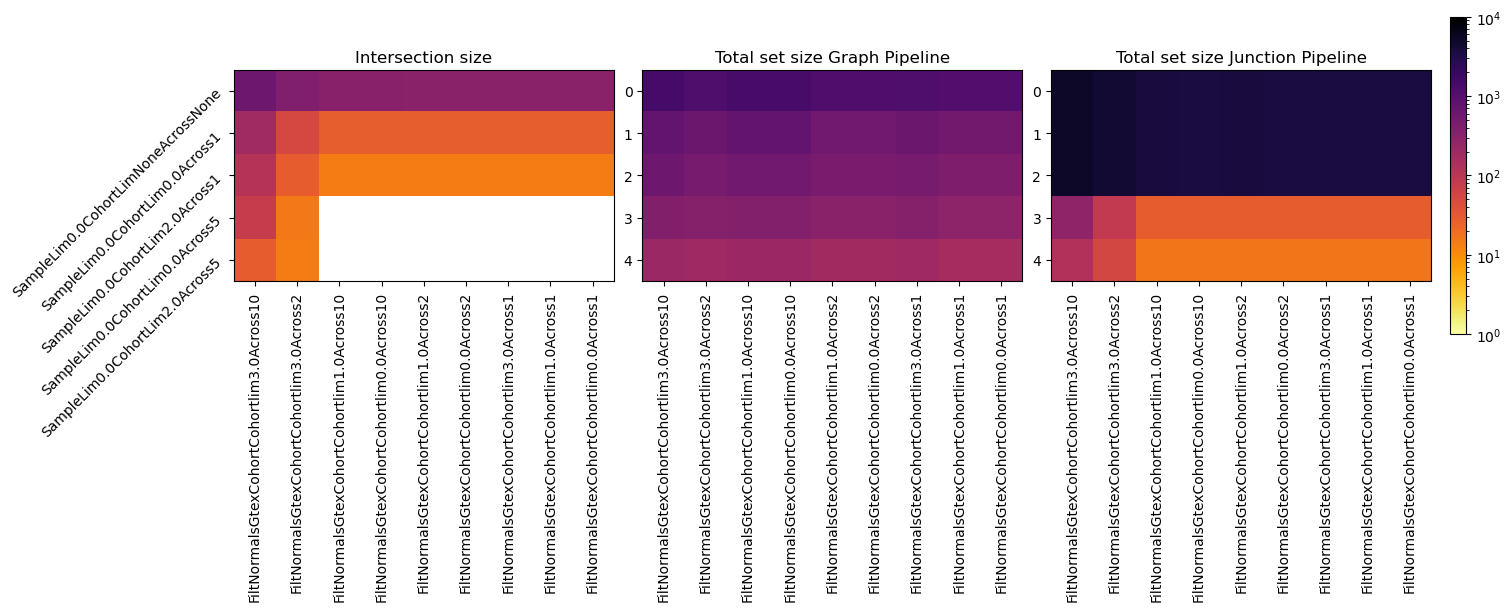

In [28]:
nprow = 1
npcol = 3
fig = plt.figure(figsize=(15, 6), layout='constrained')
axes = [fig.add_subplot(nprow, npcol, i) for i in range(1,npcol+1)]

vmin = 1
vmax = 1e5
for pane_idx in np.arange(npcol):
    panelplot=axes[pane_idx].imshow(df_plot[pane_idx], origin='upper', 
                                    cmap='inferno_r', norm=LogNorm(vmin=1, vmax=1e4))
    axes[pane_idx].set_title(titles[pane_idx])
    axes[pane_idx].set_xticks(range(df_plot[pane_idx].shape[1]))
    axes[pane_idx].set_xticklabels(df_plot[pane_idx].columns, rotation = 90 )
    if pane_idx == 0 :
        axes[pane_idx].set_yticks(range(df_plot[pane_idx].shape[0]))
        axes[pane_idx].set_yticklabels(df_plot[pane_idx].index, rotation = 45 )
plt.colorbar(panelplot)

save = True
name = 'Matrix_ovelap'
save_path = os.path.join(plot_dir, f'{base_plot}_{name}.pdf')
if save:
    print("save to {}".format(save_path))
    plt.savefig(save_path, bbox_inches='tight')
    
fig.show()


In [23]:
df_plot[1]

filter_background,FiltNormalsGtexCohortCohortlim3.0Across10,FiltNormalsGtexCohortCohortlim3.0Across2,FiltNormalsGtexCohortCohortlim1.0Across10,FiltNormalsGtexCohortCohortlim0.0Across10,FiltNormalsGtexCohortCohortlim1.0Across2,FiltNormalsGtexCohortCohortlim0.0Across2,FiltNormalsGtexCohortCohortlim3.0Across1,FiltNormalsGtexCohortCohortlim1.0Across1,FiltNormalsGtexCohortCohortlim0.0Across1
filter_foreground,,,,,,,,,
SampleLim0.0CohortLimNoneAcrossNone,1411,1188,1381,1381,1120,1120,1187,1070,1070
SampleLim0.0CohortLim0.0Across1,769,606,739,739,554,554,606,533,533
SampleLim0.0CohortLim2.0Across1,585,486,556,556,442,442,486,421,421
SampleLim0.0CohortLim0.0Across5,374,346,354,354,311,311,346,293,293
SampleLim0.0CohortLim2.0Across5,214,198,207,207,183,183,198,165,165


In [24]:
df_plot[2]

filter_background,FiltNormalsGtexCohortCohortlim3.0Across10,FiltNormalsGtexCohortCohortlim3.0Across2,FiltNormalsGtexCohortCohortlim1.0Across10,FiltNormalsGtexCohortCohortlim0.0Across10,FiltNormalsGtexCohortCohortlim1.0Across2,FiltNormalsGtexCohortCohortlim0.0Across2,FiltNormalsGtexCohortCohortlim3.0Across1,FiltNormalsGtexCohortCohortlim1.0Across1,FiltNormalsGtexCohortCohortlim0.0Across1
filter_foreground,,,,,,,,,
SampleLim0.0CohortLimNoneAcrossNone,5136,4224,3690,3643,3690,3643,3643,3643,3643
SampleLim0.0CohortLim0.0Across1,5136,4224,3690,3643,3690,3643,3643,3643,3643
SampleLim0.0CohortLim2.0Across1,5136,4224,3690,3643,3690,3643,3643,3643,3643
SampleLim0.0CohortLim0.0Across5,266,84,29,29,29,29,29,29,29
SampleLim0.0CohortLim2.0Across5,127,53,16,16,16,16,16,16,16
